In [181]:
%run -i ../../../utils/grid_visualization.py

In [179]:
from gridworld.data import SingleTurnIGLUDataset  # Or IGLUDataset for multiturn
from gridworld.tasks import Tasks, Task

In [3]:
BLOCK_COLOR_ID_MAP

{1: 'blue', 2: 'green', 3: 'red', 4: 'orange', 5: 'purple', 6: 'yellow'}

In [4]:
iglu_dataset = SingleTurnIGLUDataset(task_kwargs={'invariant': True})
print(f'total structures: {len(iglu_dataset.tasks)}')
print(f'total sessions: {len(sum(iglu_dataset.tasks.values(), []))}')

total structures: 711
total sessions: 3605


## Select task

In [280]:
selected_tasks = [
    #('19-c126/step-10', 1),  # Red mug with orange handle
    #('7-c97/step-2', 2),  # Orange corner
    ('2-c97/step-4', 7),  # Red and orange platform
    #('13-c139/step-2', 1),  # Red and yellow tower
    #('11-c27/step-4', 1),  # Big blue L shape
]

### Coordinate explanation

x coordinate decreases towards west, the y coordinate increases towards the sky and the z coordinate increases towards south.
y coordinate increases when moving up, and it's lowest value is -1. The -2 value corresponds to the floor, which is ignored.

For visualization the y axis will be increased so the lowest value is now 0 and the floor is coordinate -1. This will make the coordinate (0, 0, 0) the northeast corner of the grid.

When converting the task to dense, the new order of coordinates is (y, x, z)

Examples:
* `Facing west, walk forwards a little bit, then place a tower of four blue blocks.` places the tower increasing the x value.
* `Facing north, place a tower of four blue blocks two spaces to the right` places a the tower towards east, decreasing the x value.

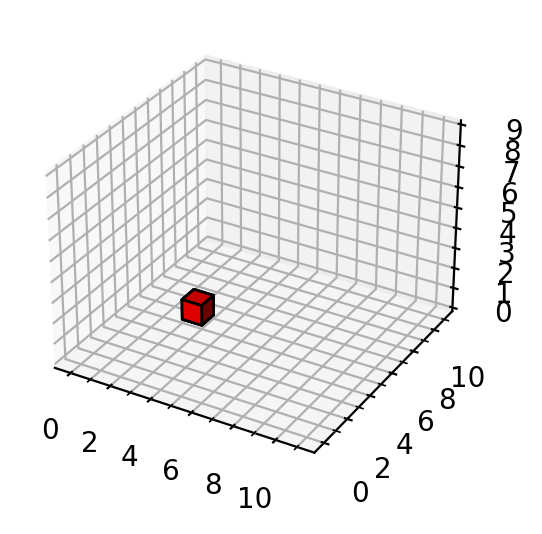

In [281]:
task = iglu_dataset.tasks[selected_tasks[0][0]][selected_tasks[0][1]]
plot_grid(
    Tasks.to_dense(task.starting_grid), figsize=(3,3),
    fontsize=5);

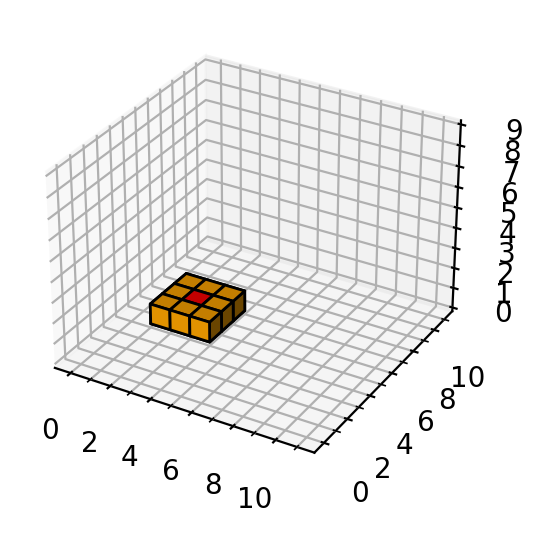

In [282]:
plot_grid(
    task.target_grid, figsize=(3,3),
    fontsize=5);

## Generate prompt

In [283]:
import numpy
from collections import defaultdict

def dense_grid_to_sparse(dense_grid):
    # For some reason, Tasks.to_sparse(Tasks.to_dense(sparse_grid)) != sparse_grid
    # so we need this function to convert the target_grid to the correct format.
    dense_grid = dense_grid.transpose(1, 0, 2)
    return [(x - 5, y - 1, z - 5, dense_grid[x, y, z]) for x, y, z in zip(*numpy.where(dense_grid != 0))]


def describe_grid(grid):
    """grid is an sparse gridworld grid, the result of dense_grid_to_sparse(dense_grid)"""
    if len(grid) == 0:
        return 'no blocks'

    grid_blocks_by_id = defaultdict(list)
    grid_description = []
    for x, y, z, color in grid:
        grid_blocks_by_id[color].append((x, y + 1, z))
    for color_id, coordinates in grid_blocks_by_id.items():
        color = BLOCK_COLOR_ID_MAP[color_id]
        grid_description.append(f'{len(coordinates)} {color} blocks in positions ' + ' '.join([str(c[:3]) for c in coordinates]))
    return ', '.join(grid_description)


def describe_task(gridworld_task):
    starting_grid_description = describe_grid(gridworld_task.starting_grid)
    target_grid_description = describe_grid(dense_grid_to_sparse(gridworld_task.target_grid))

    return starting_grid_description, target_grid_description

Paste the prompt on the model API

In [292]:
task = iglu_dataset.tasks[selected_tasks[0][0]][selected_tasks[0][1]]

starting_grid_description, target_grid_description = describe_task(task)
print(starting_grid_description)
print(task.last_instruction.replace('<Architect> ', ''))
print(target_grid_description)
print()

prompt_prefix = ('Coordinates are (x, y, z). x coordinate decreases towards west, the y coordinate increases towards the sky and the z coordinate increases towards south.'
                 ' For example, if the grid has a column of 3 blue blocks in positions (3, 0, 1) (3, 1, 1) (3, 2, 1),'
                 ' to build a column 5 blocks high in the south east corner, the new grid is (3, 0, 1) (3, 1, 1) (3, 1, 1) (-5, 0, 5) (-5, 1, 5) (-5, 2, 5) (-5, 3, 5) (-5, 4, 5).\n'
                 ' Given a grid that has, facing North, ')
prompt_suffix = 'Give me a list of coordinates of the new grid relative to the center of the grid. '
prompt = prompt_prefix + starting_grid_description + task.last_instruction.replace('<Architect> ', '') + '\n ' + prompt_suffix
print(prompt)

1 red blocks in positions (-3, 0, 0)
Place eight orange blocks around the red block in a single layer
8 orange blocks in positions (-4, 0, -1) (-4, 0, 0) (-4, 0, 1) (-3, 0, -1) (-3, 0, 1) (-2, 0, -1) (-2, 0, 0) (-2, 0, 1), 1 red blocks in positions (-3, 0, 0)

Coordinates are (x, y, z). x coordinate decreases towards west, the y coordinate increases towards the sky and the z coordinate increases towards south. For example, if the grid has a column of 3 blue blocks in positions (3, 0, 1) (3, 1, 1) (3, 2, 1), to build a column 5 blocks high in the south east corner, the new grid is (3, 0, 1) (3, 1, 1) (3, 1, 1) (-5, 0, 5) (-5, 1, 5) (-5, 2, 5) (-5, 3, 5) (-5, 4, 5).
 Given a grid that has, facing North, 1 red blocks in positions (-3, 0, 0)Place eight orange blocks around the red block in a single layer
 Give me a list of coordinates of the new grid relative to the center of the grid. 


## Parse response

In [285]:
import re
import json

In [286]:
def parse_grid(string):
    coordinate_regex = r'\(*?-?\d+\.?\d*,\s*-?\d+\.?\d*,\s*-?\d+\.?\d*\)*'
    clean_coordinates = []
    for str_coordinate in re.findall(coordinate_regex, string):
        if (str_coordinate.startswith('(') and str_coordinate.endswith(')')):
            clean_coordinates.append(str_coordinate.replace('(', '[').replace(')', ']'))
        else:
            clean_coordinates.append('[' + str_coordinate + ']')
    # Default to blue since we are not including color data in prompts
    return [tuple(json.loads(str_coordinate) + [1]) for str_coordinate in clean_coordinates]

Paste the answer you got here

(-3, 0, 0, 1), (0, 0, 0, 1), (-2, 1, 0, 1), (-1, 1, 0, 1), (0, 1, 0, 1), (1, 1, 0, 1), (2, 1, 0, 1), (-2, 0, 1, 1), (-1, 0, 1, 1), (0, 0, 1, 1), (0, 0, 0, 1)


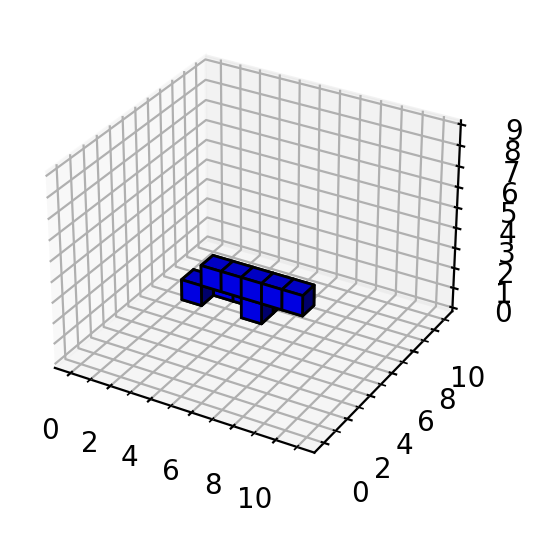

In [293]:
gpt_answer = """
The grid is a three-dimensional grid with the x-coordinate decreasing towards the west, the y-coordinate increasing towards the sky, and the z-coordinate increasing towards the south. In this scenario, there is a red block at position (-3, 0, 0), and you want to place eight orange blocks in a single layer around this red block.

Assuming that the grid is centered at (0, 0, 0), the coordinates of the eight orange blocks would be as follows:

(-2, 1, 0)
(-1, 1, 0)
(0, 1, 0)
(1, 1, 0)
(2, 1, 0)
(-2, 0, 1)
(-1, 0, 1)
(0, 0, 1)
These coordinates are relative to the center of the grid, which is at (0, 0, 0). The coordinates given above assume that the red block is facing north. If the red block is facing in a different direction, the coordinates of the orange blocks would be different.
"""

answer_grid = parse_grid(gpt_answer)
print(', '.join([str(x) for x in answer_grid]))

plot_grid(
    Tasks.to_dense(answer_grid), figsize=(3,3),
    fontsize=5);

## Prompting with dataset examples

In [270]:
prompt_tasks = [
    ('11-c27/step-4', 1),  # Big blue L shape
    ('7-c97/step-2', 2),  # Orange corner
    ('19-c126/step-10', 1),  # Red mug with orange handle
]

new_task = iglu_dataset.tasks['2-c97/step-4'][7] # Red and orange platform

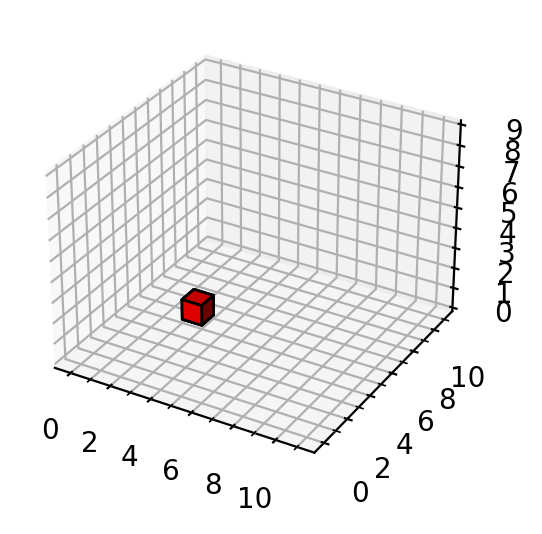

In [271]:
plot_grid(
    Tasks.to_dense(new_task.starting_grid), figsize=(3,3),
    fontsize=5);

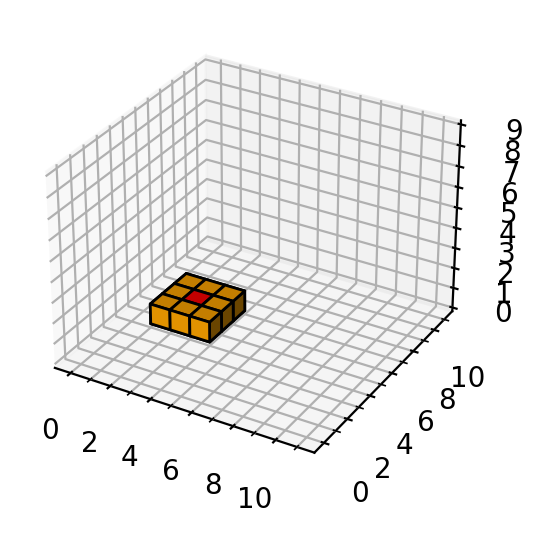

In [272]:
plot_grid(
    Tasks.to_dense(new_task.target_grid), figsize=(3,3),
    fontsize=5);

In [273]:
prompt_sentences = ''
example_prompt_template = 'Example: if the grid has {starting_grid}, then the instruction "{instruction}" gives as result the grid {target_grid}.'
example_prompt = []
for example_task_id in prompt_tasks:
    example_task = iglu_dataset.tasks[example_task_id[0]][example_task_id[1]]
    starting_grid_description, target_grid_description = describe_task(example_task)
    example_prompt.append(example_prompt_template.format(
        starting_grid=starting_grid_description, instruction=example_task.last_instruction.replace('<Architect> ', ''), target_grid=target_grid_description))
example_prompt = ' '.join(example_prompt)

starting_grid_description, target_grid_description = describe_task(new_task)

prompt_prefix = 'Coordinates are (x, y, z). x coordinate decreases towards west, the y coordinate increases towards the sky and the z coordinate increases towards south.'
instruction_prefix = 'Given a grid that has'
prompt_suffix = 'Give me a list of coordinates of the new grid relative to the center of the grid.'
instruction = new_task.last_instruction.replace('<Architect> ', '')
prompt = f'{prompt_prefix} {example_prompt} \n{instruction_prefix} {starting_grid_description} {instruction} \n{prompt_suffix}'
print(prompt)

Coordinates are (x, y, z). x coordinate decreases towards west, the y coordinate increases towards the sky and the z coordinate increases towards south. Example: if the grid has 4 blue blocks in positions (-1, 0, 0) (-1, 1, 0) (-1, 2, 0) (-1, 3, 0), then the instruction "Facing north build six blue blocks from the bottom blue block towards the east. It will look like an L shape." gives as result the grid 10 blue blocks in positions (-1, 0, 0) (-1, 1, 0) (-1, 2, 0) (-1, 3, 0) (0, 0, 0) (1, 0, 0) (2, 0, 0) (3, 0, 0) (4, 0, 0) (5, 0, 0). Example: if the grid has no blocks, then the instruction "Place an orange block where west meets north then place one orange block on each available side of the just built orange block." gives as result the grid 4 orange blocks in positions (-5, 0, -5) (-5, 0, -4) (-5, 1, -5) (-4, 0, -5). Example: if the grid has 5 orange blocks in positions (-3, 1, 1) (-3, 2, 1) (-3, 3, 1) (-2, 1, 1) (-2, 3, 1), 12 red blocks in positions (-1, 0, 1) (-1, 1, 1) (-1, 2, 1)

In [247]:
describe_task(new_task)

('1 red blocks in positions (-3, 0, 0)',
 '8 orange blocks in positions (-4, 0, -1) (-4, 0, 0) (-4, 0, 1) (-3, 0, -1) (-3, 0, 1) (-2, 0, -1) (-2, 0, 0) (-2, 0, 1), 1 red blocks in positions (-3, 0, 0)')

In [248]:
new_task.chat

'<Architect> Facing east build a red block in the 3rd place\n<Builder> Third from the top or from the side?\n<Architect> Sorry, that was an awful instruction. On the sixth row from the north, build a red block on the third space from the west.\n<Architect> Place eight orange blocks around the red block in a single layer'

(0, 0, 0, 1), (-4, 0, 0, 1), (-3, 1, 0, 1), (-2, 0, 0, 1), (-1, 0, 0, 1), (1, 0, 0, 1), (2, 0, 0, 1), (3, 1, 0, 1), (4, 0, 0, 1), (-3, 0, 0, 1)


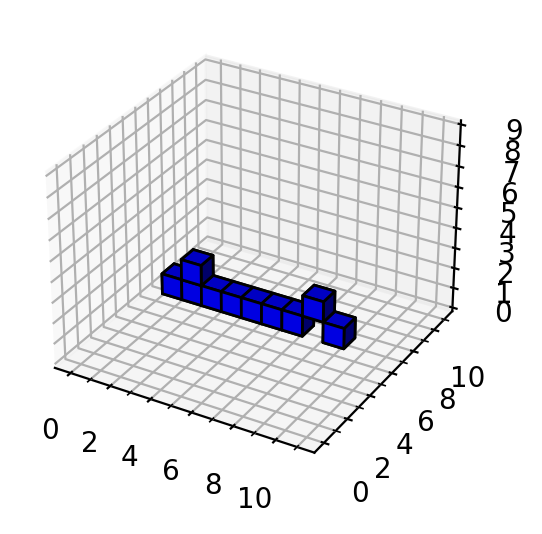

In [288]:
gpt_answer = """
Assuming the center of the grid is at position (0, 0, 0), and that the instruction to place eight orange blocks around the red block in a single layer is carried out as described, the resulting grid would have the following coordinates for the orange blocks:

(-4, 0, 0) (-3, 1, 0) (-2, 0, 0) (-1, 0, 0) (1, 0, 0) (2, 0, 0) (3, 1, 0) (4, 0, 0)

Note that the original red block would still be at position (-3, 0, 0).
"""
answer_grid = parse_grid(gpt_answer)
print(', '.join([str(x) for x in answer_grid]))
plot_grid(
    Tasks.to_dense(answer_grid), figsize=(3,3),
    fontsize=5);